In [1]:
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
from modeler.modeler import Modeler as m
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from modeler_strats.universal_modeler import UniversalModeler
import numpy as np
import matplotlib.pyplot as plt
import pickle
from functional.backtester import Backtester as b
import math
from statistics import variance

In [2]:
start_date = datetime(2023,1,1)
end_date = datetime.now()

In [3]:
market = Market()
speculation_db = ADatabase("spec")
classification_db = ADatabase("spec_classification")
current_db = ADatabase("current")
umod = UniversalModeler()

In [4]:
market.connect()
sp500 = market.retrieve("sp500")
sp500 = sp500.rename(columns={"Symbol":"ticker"})
market.disconnect()

In [5]:
bench = pd.read_csv("./csv_files/FED/SPY.csv")
bench = p.column_date_processing(bench)
bench["day"] = [x.weekday() for x in bench["date"]]
bench_returns = bench
bench_returns[f"bench_return"] = (bench_returns["adjclose"].shift(-4) - bench_returns["adjclose"].shift(-1)) / bench_returns["adjclose"].shift(-1)
bench_returns["bench_return"] = bench_returns["bench_return"].fillna(0)
bench_returns["variance"] = bench_returns["bench_return"].rolling(window=100).var()
bench_returns

,date,open,high,low,close,adjclose,volume,year,quarter,week,day,bench_return,variance
0,1993-01-25,43.968750,43.968750,43.750000,43.937500,25.122337,1003200,1993,1,4,0,-0.012510,NaN
1,1993-02-01,43.968750,45.093750,43.968750,44.968750,25.711994,2234800,1993,1,5,0,0.003504,NaN
2,1993-02-08,44.968750,45.125000,44.531250,44.593750,25.497580,1159800,1993,1,6,0,0.035150,NaN
3,1993-02-15,44.468750,44.468750,42.812500,43.562500,24.907940,998700,1993,1,7,0,0.014074,NaN
4,1993-02-22,43.687500,44.437500,43.468750,44.406250,25.390348,1024300,1993,1,8,0,0.008230,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1578,2023-04-24,411.989990,415.940002,403.779999,415.929993,415.929993,424849800,2023,2,17,0,0.014929,0.001815
1579,2023-05-01,415.470001,417.619995,403.739990,412.630005,412.630005,440398500,2023,2,18,0,0.000000,0.001809
1580,2023-05-08,412.970001,414.540009,408.869995,411.589996,411.589996,336006300,2023,2,19,0,0.000000,0.001781
1581,2023-05-15,412.220001,420.720001,410.230011,418.619995,418.619995,400138800,2023,2,20,0,0.000000,0.001780


In [6]:
tyields = pd.read_csv("./csv_files/FED/DGS1.csv")
tyields = p.column_date_processing(tyields)
tyields["dgs1"] = tyields["dgs1"].replace(".",0)
tyields["dgs1"] = tyields["dgs1"].astype("float")
tyields["yield"] = [1+(x/100) for x in tyields["dgs1"]]
tyields["weekly_yield"] = [math.exp(math.log(x)/52) for x in tyields["yield"]]
tyields

,date,dgs1,year,quarter,week,yield,weekly_yield
0,1962-01-02,3.22,1962,1,1,1.0322,1.000610
1,1962-01-03,3.24,1962,1,1,1.0324,1.000613
2,1962-01-04,3.24,1962,1,1,1.0324,1.000613
3,1962-01-05,3.26,1962,1,1,1.0326,1.000617
4,1962-01-08,3.31,1962,1,2,1.0331,1.000626
...,...,...,...,...,...,...,...
16008,2023-05-12,4.75,2023,2,19,1.0475,1.000893
16009,2023-05-15,4.73,2023,2,20,1.0473,1.000889
16010,2023-05-16,4.88,2023,2,20,1.0488,1.000917
16011,2023-05-17,4.92,2023,2,20,1.0492,1.000924


In [7]:
classification_factors = []
classification_factors.append("d1")
classification_factors.append("d2")
classification_factors.append("d3")
classification_factors.append("rolling14")

In [8]:
factors = [str(x) for x in range(14)]

In [9]:
included_columns=[
    "year",
    "week",
    "ticker",
    "adjclose",
    "y"
]
included_columns.extend(factors)
included_columns.extend(classification_factors)

In [10]:
trades = []
reqs = [0.05]
signals = [0.05]
values = [True]
classifications = [True,False]
ceilings = [True,False]
floors = [True,False]
hedges = [False]
parameters = []
positions = 10
training_year = 4
for value in values:
    for classification in classifications:
        for ceiling in ceilings:
            for floor in floors:
                for hedge in hedges:
                    for signal in signals:
                        for req in reqs:
                            parameter = {"value":value
                                         ,"classification":classification
                                         ,"ceiling":ceiling
                                         ,"floor":floor
                                         ,"hedge":hedge
                                         ,"signal":signal
                                         ,"req":req
                                         ,"training_years":training_year}
                            parameters.append(parameter)

In [11]:
training_sets = []
for ticker in tqdm(sp500["ticker"].unique()):
    try:
        prices = market.retrieve_ticker_prices("prices",ticker)
        prices = p.column_date_processing(prices)
        prices["year"] = [x.year for x in prices["date"]]
        prices["quarter"] = [x.quarter for x in prices["date"]]
        ticker_data = prices[prices["ticker"]==ticker]
        ticker_data.sort_values("date",ascending=True,inplace=True)
        ticker_data["adjclose"] = [float(x) for x in ticker_data["adjclose"]]
        ticker_data = ticker_data.groupby(["year","week"]).mean().reset_index()
        for i in range(14):
            ticker_data[str(i)] = ticker_data["adjclose"].shift(i)
        ticker_data["d1"] = ticker_data["adjclose"].pct_change(periods=1)
        ticker_data["d2"] = ticker_data["d1"].pct_change(periods=1)
        ticker_data["d3"] = ticker_data["d2"].pct_change(periods=1)
        ticker_data["rolling14"] = ticker_data["adjclose"].rolling(window=14).mean()
        ticker_data.dropna(inplace=True)
        ticker_data["ticker"] = ticker
        ticker_data["y"] = ticker_data["adjclose"].shift(-1)
        ticker_data = ticker_data.replace([np.inf, -np.inf], np.nan).dropna()
        ticker_data.dropna(inplace=True)
        ticker_data = ticker_data[included_columns]
        training_sets.append(ticker_data)
    except:
        continue
data = pd.concat(training_sets)
data = data.dropna()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 490/490 [00:42<00:00, 11.63it/s]


In [12]:
market.connect()
sp500 = market.retrieve("sp500")
sp500 = sp500.rename(columns={"Symbol":"ticker"})
market.disconnect()

In [13]:
prediction_slice = data[data["year"]==start_date.year].reset_index(drop=True)

In [14]:
speculation_db.connect()
models = speculation_db.retrieve("models")
speculation_db.disconnect()

In [15]:
classification_db.connect()
classification_models = classification_db.retrieve("models")
classification_db.disconnect()

In [16]:
simulation = umod.recommend(models,prediction_slice.copy(),factors)
simulation["week"] = simulation["week"] + 1
simulation["prediction"] = (simulation["cat_prediction"] + simulation["xgb_prediction"] + simulation["tf_prediction"]) / 3

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-03 11:17:12         2522
metadata.json                                  2023-03-03 11:17:12           64
variables.h5                                   2023-03-03 11:17:12        84160
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_absolute_percentage_error
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
290/290 [==============================] - 0s 595us/step


In [17]:
simulation

,year,week,ticker,adjclose,y,0,1,2,3,4,...,d2,d3,rolling14,xgb_prediction,xgb_score,cat_prediction,cat_score,tf_prediction,tf_score,prediction
0,2023,2,MMM,122.681938,126.880705,122.681938,118.167401,120.018608,123.209868,123.805885,...,-3.476904,7.595792,119.935581,123.393387,0.99911,123.298255,0.937924,123.487595,0.996624,123.393079
1,2023,3,MMM,126.880705,120.493744,126.880705,122.681938,118.167401,120.018608,123.209868,...,-0.104170,-0.970039,121.158728,127.931686,0.99911,126.306590,0.937924,127.037865,0.996624,127.092047
2,2023,4,MMM,120.493744,114.338678,120.493744,126.880705,122.681938,118.167401,120.018608,...,-2.470813,22.719010,122.044239,121.359016,0.99911,120.771690,0.937924,125.509865,0.996624,122.546857
3,2023,5,MMM,114.338678,114.723524,114.338678,120.493744,126.880705,122.681938,118.167401,...,0.014775,-1.005980,122.214356,114.323181,0.99911,115.482854,0.937924,121.736809,0.996624,117.180948
4,2023,6,MMM,114.723524,113.570960,114.723524,114.338678,120.493744,126.880705,122.681938,...,-1.065891,-73.143548,121.923588,114.323181,0.99911,114.572088,0.937924,119.875771,0.996624,116.257013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9265,2023,16,ZTS,171.964237,174.841118,171.964237,167.469901,164.446403,163.420608,164.111123,...,0.459632,-0.761736,165.356089,171.819336,0.99911,170.855584,0.937924,174.010620,0.996624,172.228513
9266,2023,17,ZTS,174.841118,174.408000,174.841118,171.964237,167.469901,164.446403,163.420608,...,-0.376617,-1.819388,166.749345,173.420776,0.99911,175.486834,0.937924,176.608688,0.996624,175.172100
9267,2023,18,ZTS,174.408000,179.778000,174.408000,174.841118,171.964237,167.469901,164.446403,...,-1.148074,2.048386,167.721723,173.420776,0.99911,175.486834,0.937924,178.244064,0.996624,175.717225
9268,2023,19,ZTS,179.778000,184.624000,179.778000,174.408000,174.841118,171.964237,167.469901,...,-13.429258,10.697206,168.708926,178.915390,0.99911,181.177957,0.937924,182.182175,0.996624,180.758507


In [18]:
classification_simulation = umod.recommend(classification_models,prediction_slice.copy(),classification_factors)
classification_simulation["week"] = classification_simulation["week"] + 1
classification_simulation["classification_prediction"] = ((classification_simulation["cat_prediction"] + \
                                                          classification_simulation["xgb_prediction"] + \
                                                          classification_simulation["tf_prediction"]) / 3) > 0.5

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-15 09:46:40         2141
metadata.json                                  2023-03-15 09:46:40           64
variables.h5                                   2023-03-15 09:46:40        23208
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dropout
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
290/290 [==============================] - 0s 547us/step


In [19]:
classification_simulation["classification_prediction"] = [int(x) for x in classification_simulation["classification_prediction"]]

In [20]:
new_prices = []
market.connect()
for ticker in tqdm(sp500["ticker"].unique()):
    try:
        ticker_sim = market.retrieve_ticker_prices("prices",ticker)
        ticker_sim = p.column_date_processing(ticker_sim)
        for i in range(2,5):
            ticker_sim[f"return_{i}"] = (ticker_sim["adjclose"].shift(-i) - ticker_sim["adjclose"].shift(-1)) / ticker_sim["adjclose"].shift(-1)
        ticker_sim["day"] = [x.weekday() for x in ticker_sim["date"]]
        returns = ticker_sim[ticker_sim["day"]==0]
        returns["weekly_return"] = returns["return_4"]
        new_sim = ticker_sim.merge(returns[["year","week","weekly_return"]], on=["year","week"],how="left")
        new_sim = new_sim.merge(bench_returns[["year","week","bench_return","variance"]],on=["year","week"],how="left").dropna()
        new_sim["market_cov"] = new_sim["weekly_return"].rolling(window=100).cov(new_sim["bench_return"])
        covs = new_sim["weekly_return"].rolling(window=100).cov(new_sim["bench_return"])
        completed = new_sim.copy()
        completed["beta"] = completed["market_cov"] / completed["variance"]
        completed  = completed.dropna().groupby(["date","ticker"]).mean().reset_index()
        new_prices.append(completed)
    except:
        continue
market.disconnect()
price_returns = pd.concat(new_prices)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 490/490 [00:43<00:00, 11.34it/s]


In [21]:
sim = price_returns.merge(simulation[["year","week","ticker","prediction"]],on=["year","week","ticker"],how="left") \
                    .merge(classification_simulation[["year","week","ticker","classification_prediction"]],on=["year","week","ticker"],how="left") \
                    .merge(tyields[["date","weekly_yield"]],on="date",how="left")


In [22]:
sim["projected_return"] = (sim["prediction"] - sim["adjclose"]) / sim["adjclose"]
sim["delta"] = [abs(x) for x in sim["projected_return"]]
sim["delta_sign"] = [1 if x >= 0 else -1 for x in sim["projected_return"]]
sim["market_return"] = math.exp(np.log(1.15)/52)
sim["rrr"] = sim["weekly_yield"] + sim["beta"] * (sim["market_return"] - sim["weekly_yield"]) - 1

In [23]:
sim.sort_values(["date","delta"]).tail(10)

,date,ticker,close,high,low,open,volume,adjclose,adjhigh,adjlow,...,market_cov,beta,prediction,classification_prediction,weekly_yield,projected_return,delta,delta_sign,market_return,rrr
2192939,2023-05-15,VNO,12.96,13.1400,12.55,12.81,3943597.0,12.96,13.1400,12.55,...,-0.000323,-0.181483,14.377550,1.0,1.000889,0.109379,0.109379,1,1.002691,0.000562
1621591,2023-05-15,OKE,57.95,60.2200,56.48,59.45,20718307.0,57.95,60.2200,56.48,...,-0.000138,-0.077603,64.451176,1.0,1.000889,0.112186,0.112186,1,1.002691,0.000749
349294,2023-05-15,BKNG,2646.07,2653.0850,2620.95,2626.99,198706.0,2646.07,2653.0850,2620.95,...,0.000047,0.026532,2953.085272,1.0,1.000889,0.116027,0.116027,1,1.002691,0.000937
429709,2023-05-15,CTLT,33.19,33.3500,31.45,32.15,9022711.0,33.19,33.3500,31.45,...,-0.000137,-0.077192,37.119210,1.0,1.000889,0.118385,0.118385,1,1.002691,0.000750
1642432,2023-05-15,PARA,15.81,15.8100,15.00,15.20,14599730.0,15.81,15.8100,15.00,...,-0.000135,-0.075687,17.702638,1.0,1.000889,0.119711,0.119711,1,1.002691,0.000753
1236129,2023-05-15,KEY,9.59,9.6100,8.99,9.05,22334746.0,9.59,9.6100,8.99,...,-0.000359,-0.201837,10.797877,0.0,1.000889,0.125952,0.125952,1,1.002691,0.000525
1519329,2023-05-15,NWL,9.28,9.3247,9.13,9.27,5386498.0,9.28,9.3247,9.13,...,-0.000122,-0.068264,10.519744,1.0,1.000889,0.133593,0.133593,1,1.002691,0.000766
1592110,2023-05-15,NVR,5898.82,5900.0000,5768.20,5813.61,22406.0,5898.82,5900.0000,5768.20,...,0.000113,0.063245,5028.008205,1.0,1.000889,-0.147625,0.147625,-1,1.002691,0.001003
698356,2023-05-15,DISH,6.57,6.6400,6.17,6.25,12357415.0,6.57,6.6400,6.17,...,-0.000219,-0.123080,7.670518,0.0,1.000889,0.167507,0.167507,1,1.002691,0.000667
1330341,2023-05-15,LUMN,2.49,2.5200,2.37,2.38,16709914.0,2.49,2.5200,2.37,...,0.000119,0.067106,5.675445,1.0,1.000889,1.279295,1.279295,1,1.002691,0.001010


In [24]:
current_db.connect()
current_db.drop("trades")
for parameter in tqdm(parameters):
    b.backtest(sim.copy(),parameter,start_date,end_date,current_db)
current_db.disconnect()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:14<00:00,  1.77s/it]


In [25]:
current_db.connect()
t = current_db.retrieve("trades")
current_db.disconnect()

In [26]:
t = t.fillna(1)

In [27]:
analysis = []
indexer = list(parameters[0].keys())
for parameter in parameters:
    try:
        ledger = t.sort_values(["year","week"])
        for key in parameter.keys():
            ledger = ledger[ledger[key]==parameter[key]]
        portfolio = ledger.pivot_table(index=["year","week"],columns="position",values="actual_returns").fillna(1).reset_index()
        counted_columns = [x for x in range(positions)]
        cumulative = portfolio[[i for i in counted_columns]].cumprod()
        cumulative["date_string"] = [f'{int(row[1]["year"])}-W{int(row[1]["week"])}' for row in portfolio.iterrows()]
        cumulative["date"] = [datetime.strptime(x + '-1', '%G-W%V-%u') for x in cumulative["date_string"]]
        cumulative["pv"] = [sum([row[1][column] * 0.1 for column in counted_columns]) for row in cumulative.iterrows()]
        cumulative = cumulative.merge(bench_returns[["date","adjclose","bench_return","variance"]],on="date",how="left")
        cumulative["bench"] = [1 + (row[1]["adjclose"] - cumulative["adjclose"].iloc[0]) / cumulative["adjclose"].iloc[0] for row in cumulative.iterrows()]
        cumulative["return"] = cumulative["pv"].pct_change().fillna(1)
        cumulative["beta"] = cumulative[["return","bench_return"]].cov().iloc[0][1]/cumulative["variance"].iloc[-1]
        cumulative["rrr"] = tyields["yield"].iloc[-1] + cumulative["beta"].iloc[-1]*(cumulative["bench"].iloc[-1]-tyields["yield"].iloc[-1])
        cumulative["sharpe"] = (cumulative["pv"] - tyields["yield"].iloc[-1]) / cumulative["beta"].iloc[-1]
        for index_stuff in indexer:
            cumulative[index_stuff] = parameter[index_stuff]
        analysis.append(cumulative[indexer + ["pv","beta","rrr","sharpe"]].iloc[-1])
    except Exception as e:
        print(str(e))
        continue
a = pd.DataFrame(analysis)

In [28]:
a.sort_values("pv",ascending=False)

,value,classification,ceiling,floor,hedge,signal,req,training_years,pv,beta,rrr,sharpe
16,True,True,True,True,False,0.05,0.05,4,1.069395,0.840584,1.053813,0.022836
16,True,True,False,True,False,0.05,0.05,4,1.069395,0.840584,1.053813,0.022836
16,True,False,True,True,False,0.05,0.05,4,1.008258,0.845481,1.053834,-0.049607
16,True,False,False,True,False,0.05,0.05,4,1.008258,0.845481,1.053834,-0.049607
16,True,True,True,False,False,0.05,0.05,4,0.935497,0.887963,1.054017,-0.129176
16,True,True,False,False,False,0.05,0.05,4,0.935497,0.887963,1.054017,-0.129176
16,True,False,True,False,False,0.05,0.05,4,0.889603,0.921416,1.054161,-0.174294
16,True,False,False,False,False,0.05,0.05,4,0.889603,0.921416,1.054161,-0.174294


In [29]:
top = a.sort_values("pv",ascending=False).iloc[0]
analysis = t.copy()
for key in parameter.keys():
    analysis = analysis[(analysis[key]==top[key])]
ledger = analysis[["year","week","ticker","delta","actual_returns","position"]]
ledger = ledger.merge(sp500[["ticker","GICS Sector","Security"]],on="ticker",how="left")

In [30]:
t.columns

Index(['year', 'week', 'ticker', 'delta_sign', 'delta', 'returns',
       'floored_returns', 'position', 'actual_returns', 'value',
       'classification', 'ceiling', 'floor', 'hedge', 'signal', 'req',
       'training_years'],
      dtype='object')

In [31]:
ledger.sort_values(["week","position"]).to_csv("current.csv")

In [32]:
portfolio = ledger.pivot_table(index=["year","week"],columns="position",values="actual_returns").fillna(1).reset_index()
counted_columns = [x for x in range(ledger["position"].max()+1)]
for col in range(positions):
    if col not in counted_columns:
        portfolio[col] = 1
portfolio.reset_index()

position,index,year,week,0,1,2,3,4,5,6,7,8,9
0,0,2023.0,2.0,1.053571,0.980324,0.966095,1.069617,0.973491,0.950000,0.950000,0.950000,1.022927,0.950000
1,1,2023.0,4.0,0.988896,0.950000,0.950000,1.008411,0.959044,0.950000,0.991230,0.990629,0.967626,0.957395
2,2,2023.0,5.0,1.001905,0.950000,0.950000,0.977534,0.978208,1.043265,0.950000,0.991385,0.971702,1.007282
3,3,2023.0,6.0,0.950000,1.015647,1.091170,1.084794,0.950000,0.950000,0.980311,1.084495,0.950000,0.973610
4,4,2023.0,7.0,0.996342,0.950000,1.008988,1.011023,1.049663,0.983873,1.035481,0.977190,0.985108,0.983162
5,5,2023.0,9.0,0.984224,1.004343,0.985797,1.038193,1.006414,1.000082,0.998375,1.008837,1.009603,1.083679
6,6,2023.0,10.0,0.978407,1.012723,0.950000,0.961840,0.950000,0.954697,1.043016,0.950000,0.983516,0.950000
7,7,2023.0,11.0,0.968492,1.036014,0.950000,1.026415,0.950000,0.974289,0.950000,0.956392,0.950000,0.950000
8,8,2023.0,12.0,0.950000,0.972630,0.950000,1.012630,0.966839,0.950000,0.972118,0.995719,0.950000,0.961313
9,9,2023.0,13.0,1.022006,1.074885,1.083921,1.081849,0.988285,1.072655,1.059680,1.027545,1.076034,1.027506


In [33]:
counted_columns

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [34]:
counted_columns = [x for x in range(positions)]
cumulative = portfolio[[i for i in counted_columns]].cumprod()
cumulative["date_string"] = [f'{int(row[1]["year"])}-W{int(row[1]["week"])}' for row in portfolio.iterrows()]
cumulative["date"] = [datetime.strptime(x + '-1', '%G-W%V-%u') for x in cumulative["date_string"]]
cumulative["pv"] = [sum([row[1][column] * 0.1 for column in counted_columns]) for row in cumulative.iterrows()]
bench = pd.read_csv("./csv_files/FED/SPY.csv")
bench = p.column_date_processing(bench)
cumulative = cumulative.merge(bench[["date","adjclose"]],on="date",how="left")
cumulative["bench"] = [1 + (row[1]["adjclose"] - cumulative["adjclose"].iloc[0]) / cumulative["adjclose"].iloc[0] for row in cumulative.iterrows()]
cumulative

,0,1,2,3,4,5,6,7,8,9,date_string,date,pv,adjclose,bench
0,1.053571,0.980324,0.966095,1.069617,0.973491,0.950000,0.950000,0.950000,1.022927,0.950000,2023-W2,2023-01-09,0.986602,396.984894,1.000000
1,1.041873,0.931307,0.917791,1.078613,0.933621,0.902500,0.941669,0.941098,0.989810,0.909525,2023-W4,2023-01-23,0.958781,404.137604,1.018018
2,1.043858,0.884742,0.871901,1.054380,0.913276,0.941547,0.894585,0.932990,0.961800,0.916148,2023-W5,2023-01-30,0.941523,410.782257,1.034755
3,0.991665,0.898585,0.951392,1.143786,0.867612,0.894469,0.876972,1.011824,0.913710,0.891971,2023-W6,2023-02-06,0.944199,406.488647,1.023940
4,0.988037,0.853656,0.959944,1.156394,0.910700,0.880045,0.908088,0.988744,0.900102,0.876952,2023-W7,2023-02-13,0.942266,405.711609,1.021982
5,0.972450,0.857364,0.946310,1.200561,0.916542,0.880117,0.906612,0.997482,0.908746,0.950334,2023-W9,2023-02-27,0.953652,402.653259,1.014279
6,0.951451,0.868272,0.898994,1.154748,0.870715,0.840245,0.945611,0.947608,0.893767,0.902817,2023-W10,2023-03-06,0.927423,384.442780,0.968407
7,0.921473,0.899543,0.854045,1.185250,0.827179,0.818642,0.898331,0.906284,0.849079,0.857677,2023-W11,2023-03-13,0.901750,388.507233,0.978645
8,0.875399,0.874922,0.811342,1.200220,0.799749,0.777710,0.873284,0.902404,0.806625,0.824496,2023-W12,2023-03-20,0.874615,395.750000,0.996889
9,0.894664,0.940440,0.879431,1.298457,0.790380,0.834215,0.925401,0.927261,0.867955,0.847174,2023-W13,2023-03-27,0.920538,409.390015,1.031248


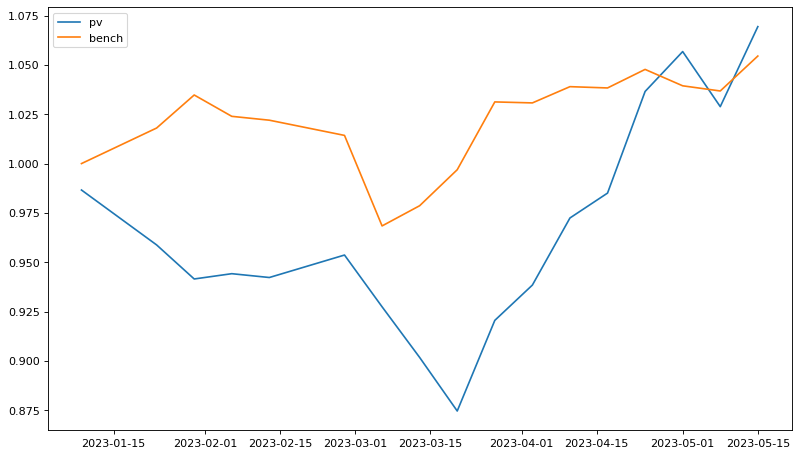

In [35]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

In [36]:
industry_analysis = ledger.pivot_table(index=["year","week"],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x not in  ["year","week"]]].cumprod()

GICS Sector,Communication Services,Consumer Discretionary,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,1.038249,0.954024,1.000000,1.000000,0.980324,0.950000,1.021554,1.000000,1.000000,1.000000
1,1.016659,0.922310,1.000000,1.000000,0.980324,0.939452,0.987242,1.000000,1.000000,1.000000
2,0.992211,0.910239,1.000000,0.963767,0.987462,0.939452,0.987242,1.000000,1.000000,1.000000
3,0.989290,0.905535,1.000000,0.963767,1.011837,0.939452,0.967805,1.000000,1.000000,1.000000
4,0.989290,0.896701,1.000000,0.963767,1.011837,0.939452,0.976948,1.000000,1.000000,1.011023
5,0.989370,0.916804,1.000000,0.963767,1.011837,0.939452,0.980471,1.000000,1.000000,1.011023
6,0.939901,0.889844,1.000000,0.963767,1.055362,0.939452,0.936052,0.983516,1.000000,1.011023
7,0.939901,0.878070,1.000000,0.915579,1.055362,0.892479,0.933669,0.983516,0.953196,1.011023
8,0.939901,0.872502,1.000000,0.869800,1.020366,0.892479,0.902592,0.983516,0.905536,1.011023
9,1.010286,0.908138,1.000000,0.898109,1.020366,0.892479,0.955615,0.983516,0.981529,1.011023
